# Extract disease features using VQ-VAE

In [1]:
import torch
import pickle
import os
import random
import gc
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import random_split

# Seed for reproduction
np.random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

#===========================================================
# Hyperparameters
#===========================================================

# Learning rate of VQ-VAE model
LR =2e-3

# Batch size
BATCH = 64

# Training epochs default= 500
EPOCH = 10

# GENE_NUM = 978 # Length of gene expression profile

# Lyer size of VQ-VAE encoder (978 -> 1000 -> 512 -> 256)
EMB_DIM = [1000, 512, 256]
# EMB_DIM = [2048, 1024, 512]  # Lyer size of VQ-VAE encoder (978 -> 1000 -> 512 -> 256)
# EMB_DIM = [4096, 2048, 1024]  # Lyer size of VQ-VAE encoder (978 -> 1000 -> 512 -> 256)

# Codebook size
NUM_EMB = 128 # Number of embedding representations (codebook)
# NUM_EMB = 256 # Number of embedding representations (codebook)
# NUM_EMB = 512 # Number of embedding representations (codebook)

# Commitment losss parameter.
COM_COST = 0.25 # Commitment cost for VQ-VAE


#===========================================================
# Disease signatures
#===========================================================

# Disease signature type.
# PROFILE_TYPE = 'disease_signature.tabs' # disease-specific signatures
# PROFILE_TYPE = 'patient_signature.tabs' # patient-specific signatures
PROFILE_TYPE = 'disease_and_patient_signature.tabs' # disease/patient-specific signatures

# Gene expression profile file
DATA_FILE = '../../../CREEDS/processed_data/expression-based_'

# Gene scaling, e.g., when not scaling, Orig or when scaling, Std
GENE_SCALING = 'Std'

# GPU or CPU conduction
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
#===========================================================
# Show parameters.
#===========================================================

def show_gene_vae_hyperparamaters(PROFILE_TYPE=PROFILE_TYPE, DATA_FILE=DATA_FILE,
                                  EPOCH=EPOCH, NUM_EMB=NUM_EMB, BATCH=BATCH, GENE_SCALING=GENE_SCALING
                                 ):

    # Hyper-parameters
    params = {}
    print('\n\nVQ-VAE Hyperparameter Information:')
    print('='*50)
    params['PROFILE_TYPE'] = PROFILE_TYPE
    params['GENE_EXPRESSION_FILE'] = DATA_FILE
    params['GENE_EPOCHS'] = EPOCH
    params['GENE_LR'] = LR
    # params['GENE_NUM'] = args.gene_num
    params['GENE_HIDDEN_SIZES'] = EMB_DIM
    params['GENE_LATENT_SIZE'] = NUM_EMB
    params['GENE_BATCH_SIZE'] = BATCH
    params['GENE_SCALING'] = GENE_SCALING

    for param in params:
        string = param + ' ' * (5 - len(param))
        print('{}:   {}'.format(string, params[param]))
    print('='*50)
    
show_gene_vae_hyperparamaters()



VQ-VAE Hyperparameter Information:
PROFILE_TYPE:   disease_and_patient_signature.tabs
GENE_EXPRESSION_FILE:   ../../../CREEDS/processed_data/expression-based_
GENE_EPOCHS:   10
GENE_LR:   0.002
GENE_HIDDEN_SIZES:   [1000, 512, 256]
GENE_LATENT_SIZE:   128
GENE_BATCH_SIZE:   64
GENE_SCALING:   Std


In [3]:
def make_output_directory_path():

    # Meke output data directory
    o_dir = f"../data/VQ_VAE/disease/{PROFILE_TYPE}/" # profile type
    o_dir = f"{o_dir}/Epo{EPOCH}_Lr{LR}" # Epochs
    o_dir = f"{o_dir}_Hid{'_'.join([str(s) for s in sorted(EMB_DIM, reverse = True)])}" # hidden sizes
    o_dir = f"{o_dir}_Lat{NUM_EMB}" # latent size
    o_dir = f"{o_dir}_Bat{BATCH}" # batch size
    o_dir = f"{o_dir}_Comc{COM_COST}" # commitment cost
    o_dir = f"{o_dir}_Scale{GENE_SCALING}/" # scaling
    os.makedirs( o_dir, exist_ok = True ) # make directory
    return o_dir

In [6]:
#===========================================================
# Read the disease gene expression data, which contains disease ids and gene values
#===========================================================

gene_data = pd.read_csv(DATA_FILE + PROFILE_TYPE, 
                         sep = '\t',
                         index_col='disease'
                        )
gene_data = (gene_data - gene_data.mean())/gene_data.std() # Diseaseはスパースなデータなので標準化
gene_data = gene_data.dropna(how = 'any', axis = 1)


# ----- Normalize data per gene ----- #
if GENE_SCALING == 'Std': 
    gene_data = (gene_data - gene_data.mean())/gene_data.std() # Diseaseはスパースなデータなので標準化
elif GENE_SCALING == 'Orig':
    gene_data = gene_data # Original data
    
# Drop the nan row
gene_data = gene_data.dropna(how='any', axis = 1) # Remove genes with 0 for all diseases
gene_data = gene_data.values.astype('float32') # Pandas -> numpy

GENE_NUM = gene_data.shape[1] # Number of genes

print('Gene data: ', gene_data.shape) # (nums, dimension)
gene_data

Gene data:  (374, 14070)


array([[-1.4066658 ,  0.0680136 , -0.11486182, ..., -0.05578998,
        -0.05581485, -0.05583712],
       [-1.3953388 , -0.39369953, -0.11486182, ..., -0.05578998,
        -0.05581485, -0.05583712],
       [-1.3840119 ,  0.0680136 , -0.11486182, ..., -0.05578998,
        -0.05581485, -0.05583712],
       ...,
       [ 1.900813  ,  0.0680136 , -0.11486182, ..., -0.05578998,
        -0.05581485, -0.05583712],
       [ 1.9121399 ,  0.0680136 , -0.11486182, ..., -0.05578998,
        -0.05581485, -0.05583712],
       [ 1.9234669 ,  0.0680136 , -0.11486182, ..., 19.222288  ,
        19.221457  , 19.220705  ]], dtype=float32)

In [9]:
# Define GeneDataset
class GeneDataset(torch.utils.data.Dataset):
    
    def __init__(self, gene_data):
        self.gene_data = gene_data
        self.gene_rows = len(gene_data)

    def __len__(self):
        return self.gene_rows

    def __getitem__(self, idx):
        out = torch.tensor(self.gene_data[idx]).float()
        return out
    
# Get a batch of gene data for training: train_dataloader
dataset = GeneDataset(gene_data)
del gene_data
gc.collect()
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH, shuffle=True)

In [10]:
# Quantize tensors using VQ-VAE (Nearest K Neighbors)
class VectorQuantizer(nn.Module):
    
    def __init__(self, num_emb, emb_dim, com_cost):
        """
        num_emb (K): the number of vectors in the quantized space.
        emb_dim (d): the dimensionality of the tensors in the quantized space.
        com_cost: scalar which controls the weighting of the loss terms
        """
        super(VectorQuantizer, self).__init__()
        
        self.num_emb = num_emb
        self.emb_dim = emb_dim
        self.com_cost = com_cost
        self.emb = nn.Embedding(self.num_emb, self.emb_dim)
        self.emb.weight.data.uniform_(-1/self.num_emb, 1/self.num_emb)
        
    def forward(self, inputs):
        
        # Distance
        distances = (torch.sum(inputs**2, dim=1, keepdim=True) 
                    + torch.sum(self.emb.weight**2, dim=1)
                    - 2 * torch.matmul(inputs, self.emb.weight.t()))
        
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self.num_emb, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self.emb.weight).view(inputs.shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self.com_cost * e_latent_loss

         # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        
        return loss, quantized, encodings
    
class VQ_VAE(nn.Module):
    
    def __init__(
        self,  
        num_emb, 
        emb_dim, 
        com_cost
    ):
        super(VQ_VAE, self).__init__()
        
        """
        encoder_layers = []
        for index in range(1, len(emb_dim)):
            if index == 1:
                encoder_layers.append(nn.Linear(GENE_NUM, emb_dim[index-1]))
            else:
               encoder_layers.append(nn.Linear(emb_dim[index-1], emb_dim[index]))
            encoder_layers.append(nn.Tanh())
            encoder_layers.append(nn.Dropout(0.1))
        self.encoder = nn.Sequential(*encoder_layers)
        """
        
        self.encoder =  nn.Sequential(
            nn.Linear(GENE_NUM, emb_dim[0]),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(emb_dim[0], emb_dim[1]),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(emb_dim[1], emb_dim[2]),
            nn.Tanh(),
            nn.Dropout(0.1)
        )
       
        self.vq = VectorQuantizer(num_emb, emb_dim[-1], com_cost)

        """
        decoder_layers = []
        for index in range(len(emb_dim)-1, -1, -1):
            if index != 0:
                decoder_layers.append(nn.Linear(emb_dim[index], emb_dim[index-1]))
                decoder_layers.append(nn.Tanh())
                decoder_layers.append(nn.Dropout(0.1))
            else:
                decoder_layers.append(nn.Linear(emb_dim[index], GENE_NUM))
        self.decoder = nn.Sequential(*decoder_layers)
        """
        self.decoder =  nn.Sequential(
            nn.Linear(emb_dim[-1], emb_dim[-2]),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(emb_dim[-2], emb_dim[-3]),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(emb_dim[-3], GENE_NUM)
        )
            
    def forward(self, inputs):
        z = self.encoder(inputs)
        loss, quantized, _ = self.vq(z)
        x_recon = self.decoder(quantized) 

        return loss, x_recon, quantized
    
    def load_model(self, path):
        weights = torch.load(path, map_location=DEVICE)
        self.load_state_dict(weights) # Revise: delete "strict=False" (Model Changed!)

    def save_model(self, path):
        torch.save(self.state_dict(), path) # Revise: checkpoint -> state_dict()
        
model = VQ_VAE(
    num_emb=NUM_EMB,  
    emb_dim=EMB_DIM,   
    com_cost=COM_COST
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LR, amsgrad=True)

In [23]:
def show_density(save_path,  nums, trained_gene_vae=None, idx=None):
    """
    save_path: the path to save the figure
    nums: number of rows of gene expression profile data used for data distribution
    """
    real_genes = pd.read_csv(DATA_FILE + PROFILE_TYPE, 
                             sep = '\t',
                             index_col='disease'
                            )
    real_genes = (real_genes - real_genes.mean())/real_genes.std() # Diseaseはスパースなデータなので標準化
    real_genes = real_genes.dropna(how = 'any', axis = 1)

    # Normalize data per gene
    if GENE_SCALING == 'Std': 
        real_genes = (real_genes - real_genes.mean())/real_genes.std() # Diseaseはスパースなデータなので標準化
    elif GENE_SCALING == 'Orig':
        real_genes = real_genes # Original data

    # Drop the nan row
    real_genes = real_genes.dropna(how='any', axis = 1) # Remove genes with 0 for all diseases

    # Calculate average value
    if nums == 1:
#         random_rows = np.array([1])
        random_rows = np.array([idx])
    else:
        random_rows = np.random.choice(len(real_genes), nums)
        
    real_genes = real_genes.iloc[random_rows, :]
    mean_real_all_gene = real_genes.mean()

    plt.subplots(figsize=(12,7))
    plt.title("Data distribution of gene expression profile", fontsize=12)
    plt.xlabel("Values of gene expression profile data", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    # Figure density distribution
    sns.histplot(mean_real_all_gene, bins=50, kde=True, label='Real gene', color='g')
    if trained_gene_vae:
        trained_gene_vae.eval()
        # Reconstructed gene
        inputs = torch.tensor(real_genes.values, dtype=torch.float32)
        _, rec_genes, _ = trained_gene_vae(inputs) # [x,978]
        rec_genes = pd.DataFrame(rec_genes.cpu().detach().numpy())
        # Calculate average value
        mean_rec_gene = rec_genes.mean()
        # Figure density distribution
        sns.histplot(mean_rec_gene, bins=50, kde=True, label='Reconstructed gene', color='r')
    
    plt.legend()
    plt.savefig(save_path, dpi=150)

def show_one_gene_densities(model):
#     show_density(make_output_directory_path() + "one_gene_density_figure.png", 1, model)
    for idx in range(10):
        show_density(f"{make_output_directory_path()}/one_gene_density_figure_{str(idx)}.png", 1, model, idx)
    
def show_all_gene_densities(model):
    show_density(make_output_directory_path() + "all_gene_density_figure.png", 1000, model)

Epoch 1,  recon_error: 1.004, vq_loss: 0.179, total_loss: 1.182
Epoch 2,  recon_error: 1.001, vq_loss: 0.217, total_loss: 1.217
Epoch 3,  recon_error: 1.000, vq_loss: 0.213, total_loss: 1.213
Epoch 4,  recon_error: 0.999, vq_loss: 0.244, total_loss: 1.243
Epoch 5,  recon_error: 0.997, vq_loss: 0.289, total_loss: 1.286
Epoch 6,  recon_error: 0.995, vq_loss: 0.320, total_loss: 1.315
Epoch 7,  recon_error: 0.993, vq_loss: 0.341, total_loss: 1.334
Epoch 8,  recon_error: 0.992, vq_loss: 0.363, total_loss: 1.355
Epoch 9,  recon_error: 0.990, vq_loss: 0.403, total_loss: 1.393
Epoch 10,  recon_error: 0.987, vq_loss: 0.432, total_loss: 1.420
Trained VQ-VAE is saved in ../data/VQ_VAE/disease/disease_and_patient_signature.tabs//Epo10_Lr0.002_Hid1000_512_256_Lat128_Bat64_Comc0.25_ScaleStd/saved_vq_vae.pkl


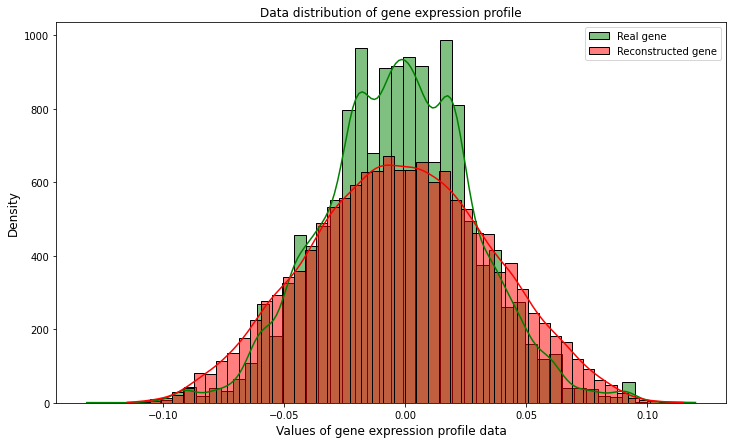

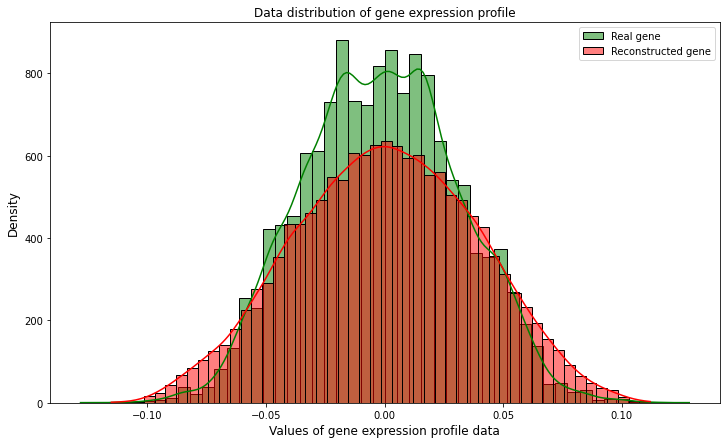

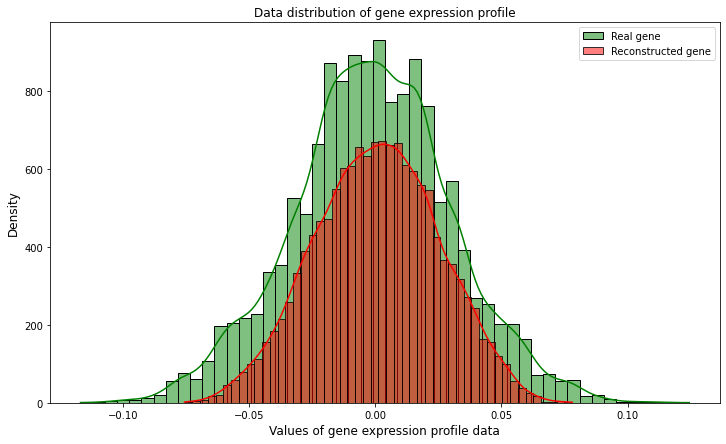

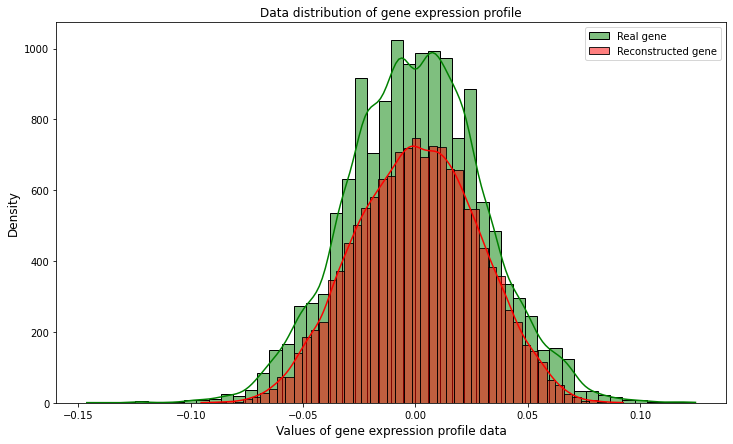

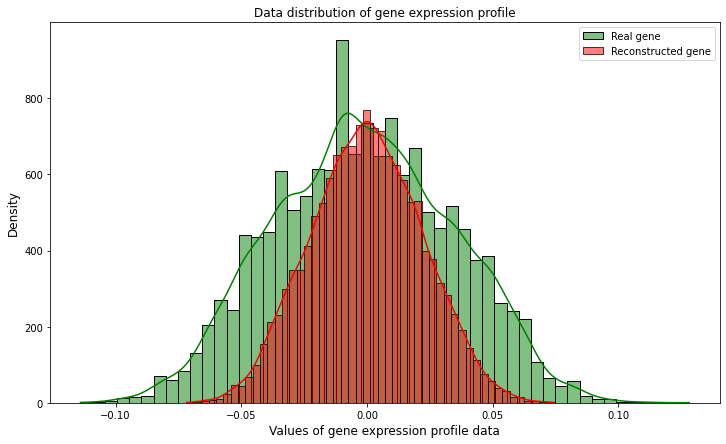

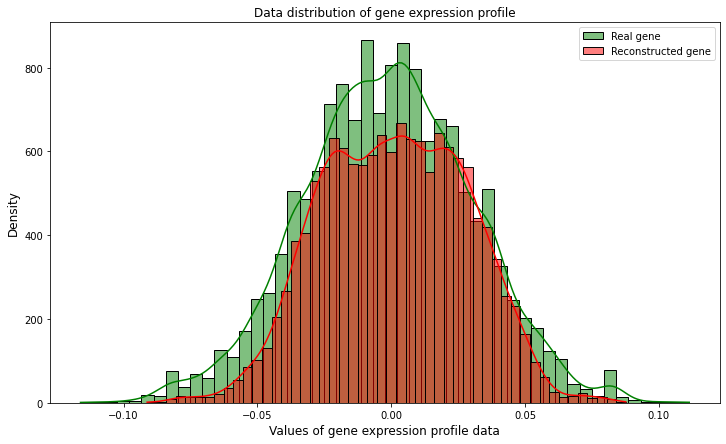

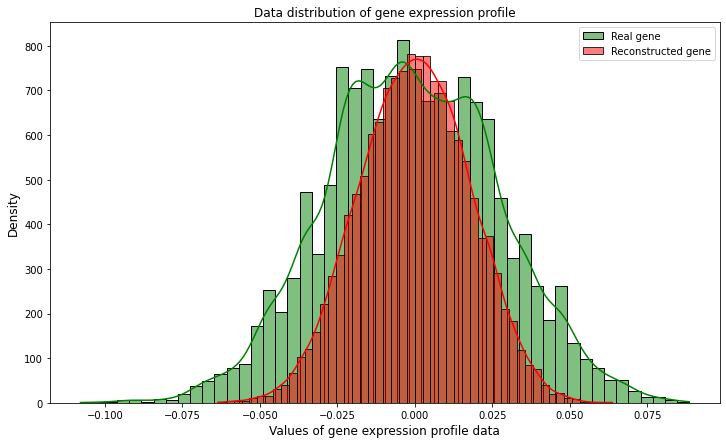

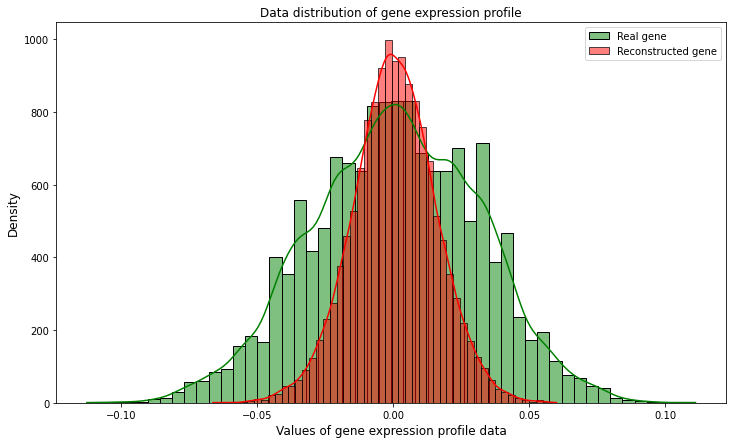

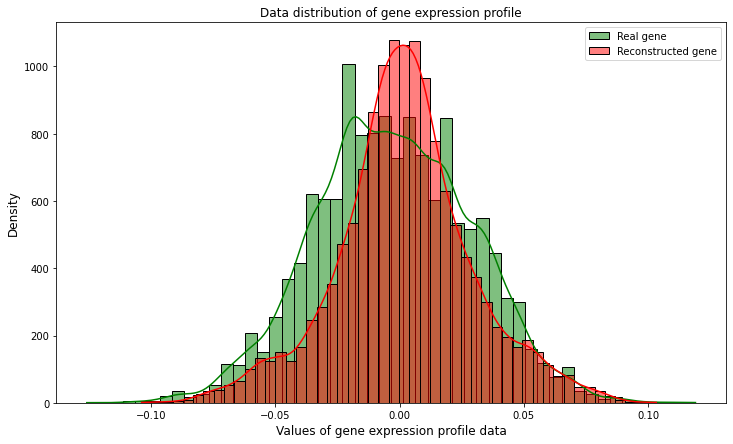

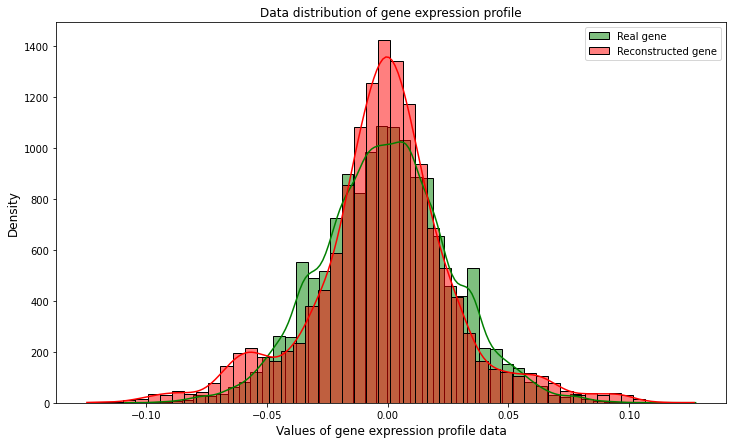

In [13]:
train_res_recon_error = []
train_loss = []
train_vq_loss = []

with open( f"{ make_output_directory_path() }/vq_vae_train_results.csv", 'a+') as wf:
        wf.truncate(0)
        wf.write('{},{},{},{}\n'.format('Epoch', 'Total', 'Rec', 'Vq'))

model.train()

for epoch in range(EPOCH):
    count =0
    for _, inputs in enumerate(train_dataloader):
        count +=1
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        vq_loss, data_recon, _ = model(inputs)
        recon_error = F.mse_loss(data_recon, inputs)
        loss = recon_error + vq_loss
        loss.backward()
        optimizer.step()

        train_res_recon_error.append(recon_error.item())
        train_loss.append(loss.item())
        train_vq_loss.append(vq_loss.item())

    ave_error = np.mean(train_res_recon_error)
    ave_vq = np.mean(train_vq_loss)
    ave_loss = np.mean(train_loss)
    print('Epoch {:d},  recon_error: {:.3f}, vq_loss: {:.3f}, total_loss: {:.3f}'.format(epoch+1, ave_error, ave_vq, ave_loss))
    
    # Save trained results to file
    with open( f"{make_output_directory_path()}/vq_vae_train_results.csv", 'a+') as wf:
        wf.write('{},{:.3f},{:.3f},{:.3f}\n'.format(epoch+1, ave_loss, ave_error, ave_vq))
    
#     show_all_gene_densities(model)
    
    
# Save trained GeneVAE
model.save_model( make_output_directory_path() + 'saved_vq_vae.pkl')
print('Trained VQ-VAE is saved in {}'.format( make_output_directory_path() + 'saved_vq_vae.pkl' ))

Load the trained VQ-VAE.
../data/VQ_VAE/disease/disease_and_patient_signature.tabs//Epo10_Lr0.002_Hid1000_512_256_Lat128_Bat64_Comc0.25_ScaleStd/saved_vq_vae.pkl
Gene expression profile distribution is created.


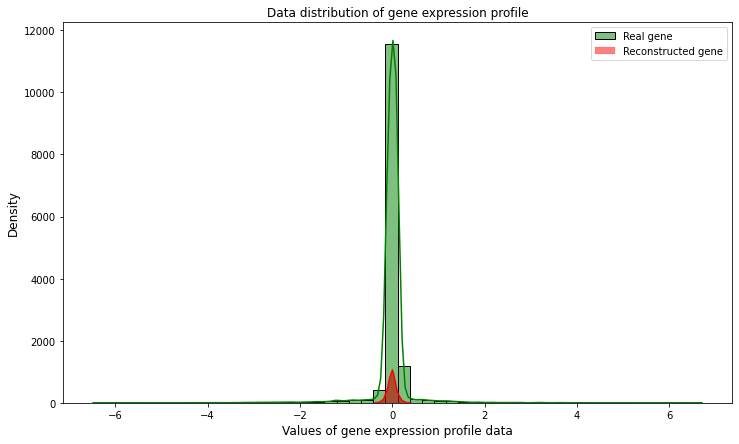

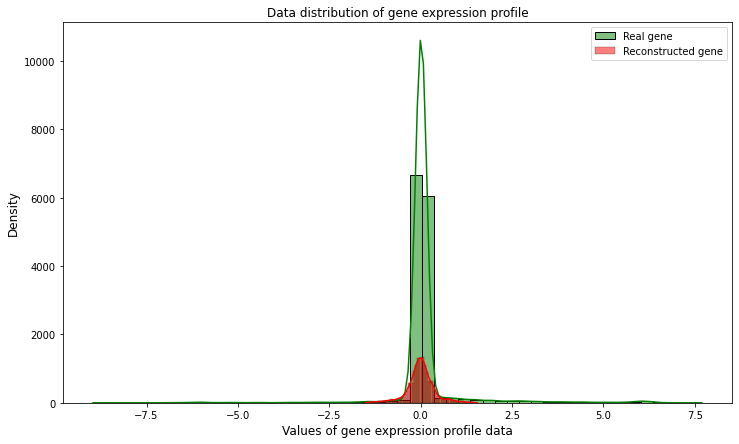

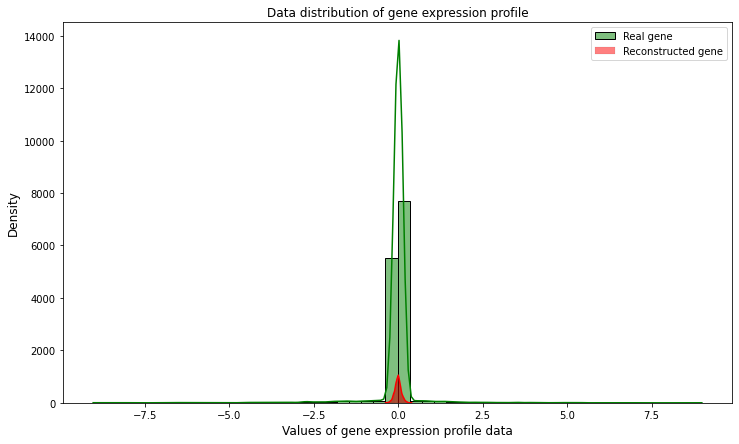

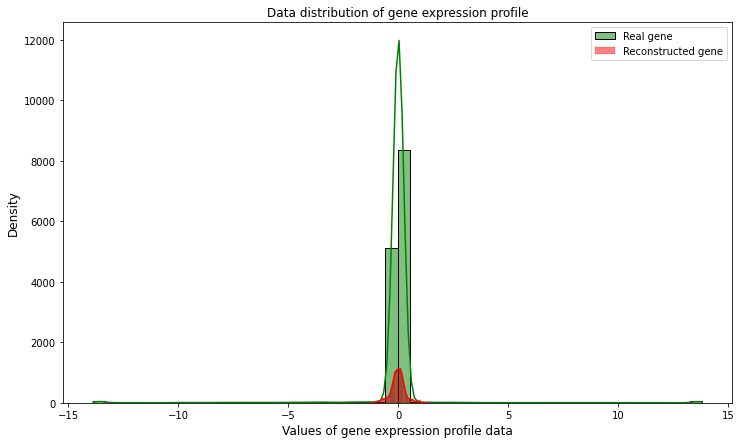

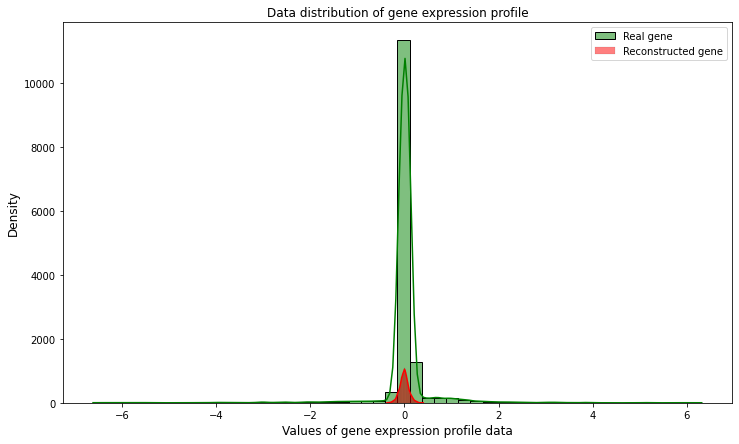

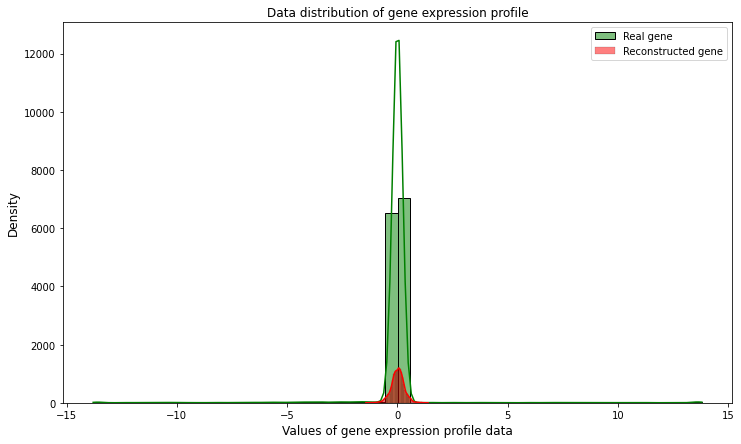

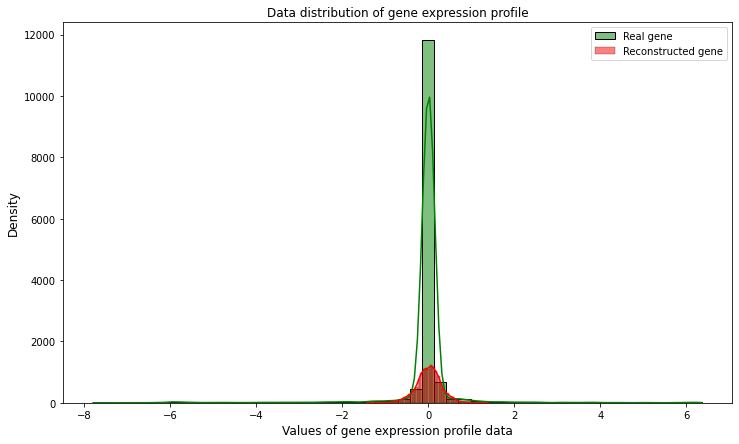

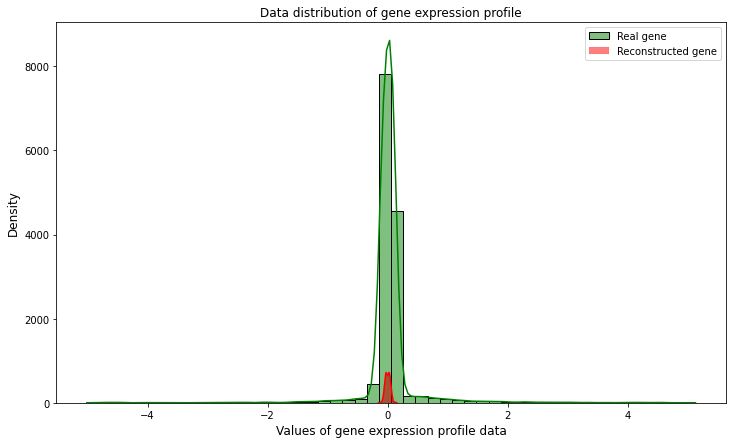

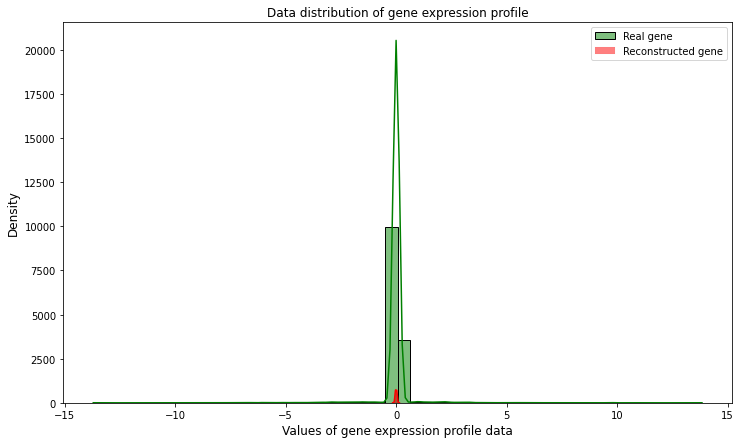

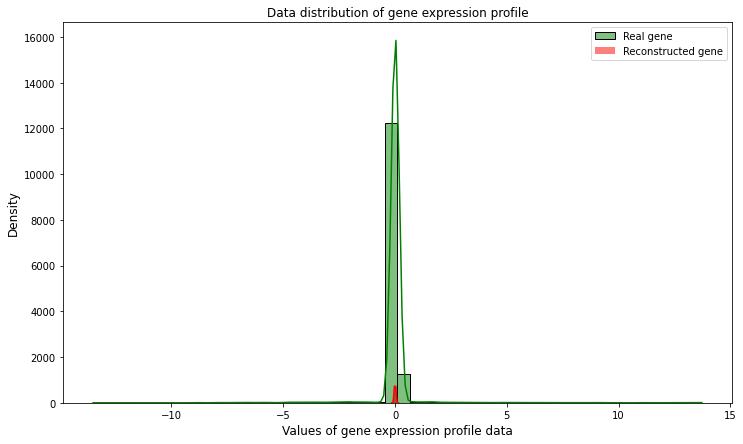

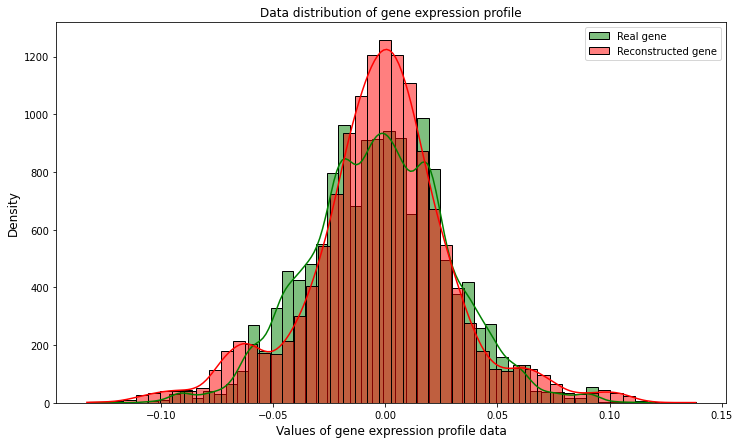

In [25]:
#  Define the trained GeneVAE  
trained_vq_vae = VQ_VAE(
    num_emb=NUM_EMB,  
    emb_dim=EMB_DIM,   
    com_cost=COM_COST
).to(DEVICE)

# Load the trained GeneVAE
# trained_gene_vae.load_model(args.saved_gene_vae + '_' + args.cell_name + '.pkl')
trained_vq_vae.load_model( make_output_directory_path() + 'saved_vq_vae.pkl') 
print('Load the trained VQ-VAE.')
print(make_output_directory_path() + 'saved_vq_vae.pkl')

# Test GeneVAE 
show_one_gene_densities( trained_vq_vae)
show_all_gene_densities( trained_vq_vae)
print('Gene expression profile distribution is created.')

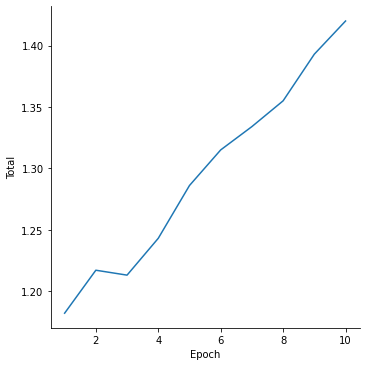

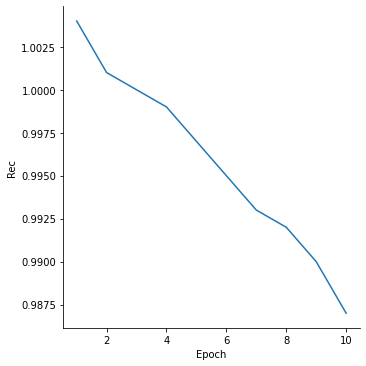

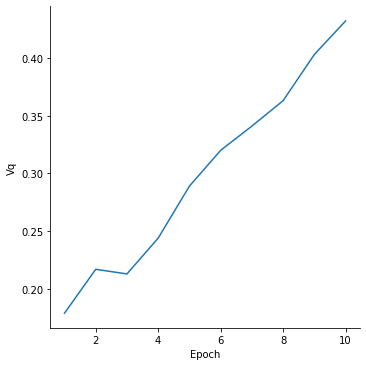

In [15]:
# Loss distribution.

loss_df = pd.read_csv(f"{ make_output_directory_path() }/vq_vae_train_results.csv", sep=',')

sns.relplot(x='Epoch', y='Total', data=loss_df, kind='line')
plt.savefig( f"{ make_output_directory_path() }/Total_loss.png", dpi=150 )
sns.relplot(x='Epoch', y='Rec', data=loss_df, kind='line')
plt.savefig( f"{ make_output_directory_path() }/Rec_loss.png", dpi=150 )
sns.relplot(x='Epoch', y='Vq', data=loss_df, kind='line')
plt.savefig( f"{ make_output_directory_path() }/Vq_loss.png", dpi=150 )
# plt.show()

In [16]:
# Extract features from gene expression profiles
# trained_vq_vae = model
trained_vq_vae.eval()
for test_genes in train_dataloader: # please use test data 
    gene_latent_vectors = trained_vq_vae.encoder(test_genes).to(DEVICE) # [batch_size, gene_latent_size]
    # Operate on a batch of gene expression features
    print(gene_latent_vectors.size())
    print(gene_latent_vectors)
    break

torch.Size([64, 256])
tensor([[ 0.9963, -0.1189,  0.8399,  ...,  0.9095,  0.7365,  0.6063],
        [-0.9777,  0.6689, -0.6383,  ..., -0.6274, -0.9013, -0.3359],
        [ 0.2398, -0.9718,  0.7988,  ...,  0.9770,  0.9910, -0.3613],
        ...,
        [-0.9561,  0.9173, -0.5478,  ...,  0.1159, -0.4178,  0.8281],
        [-0.9723,  0.4663, -0.1003,  ...,  0.9062,  0.4078,  0.9705],
        [-0.9652,  0.8259, -0.7982,  ..., -0.4250,  0.7065,  0.7043]],
       grad_fn=<TanhBackward0>)


In [17]:
#===========================================================
# Read the disease gene expression data, which contains disease ids and gene values
#===========================================================

gene_data = pd.read_csv(DATA_FILE + PROFILE_TYPE, 
                         sep = '\t',
                         index_col='disease'
                        )
gene_data = (gene_data - gene_data.mean())/gene_data.std() # Diseaseはスパースなデータなので標準化
gene_data = gene_data.dropna(how = 'any', axis = 1)


# ----- Normalize data per gene ----- #
if GENE_SCALING == 'Std': 
    gene_data = (gene_data - gene_data.mean())/gene_data.std() # Diseaseはスパースなデータなので標準化
elif GENE_SCALING == 'Orig':
    gene_data = gene_data # Original data
    
# Drop the nan row
gene_data = gene_data.dropna(how='any', axis = 1) # Remove genes with 0 for all diseases
# gene_data = gene_data.values.astype('float32') # Pandas -> numpy

GENE_NUM = gene_data.shape[1] # Number of genes

print('Gene data: ', gene_data.shape) # (nums, dimension)
gene_data

Gene data:  (374, 14070)


,Unnamed: 0,hsa:55859,hsa:23090,hsa:4830,hsa:3670,hsa:347733,hsa:10383,hsa:3397,hsa:4514,hsa:5223,...,hsa:4137,hsa:56936,hsa:83694,hsa:55659,hsa:146227,hsa:375190,hsa:79661,hsa:100506385,hsa:6899,hsa:10633
disease,,,,,,,,,,,,,,,,,,,,,
H00003,-1.406666,0.068014,-0.114862,-0.221341,0.09866,0.023014,0.300700,-0.053031,0.060783,-0.302807,...,-0.055104,-0.055315,-0.055344,-0.055489,-0.055506,-0.055593,-0.055648,-0.055790,-0.055815,-0.055837
H00004,-1.395339,-0.393700,-0.114862,0.282193,0.09866,0.023014,0.213987,-0.053031,0.060783,0.000107,...,-0.055104,-0.055315,-0.055344,-0.055489,-0.055506,-0.055593,-0.055648,-0.055790,-0.055815,-0.055837
H00005,-1.384012,0.068014,-0.114862,-0.365208,0.09866,0.023014,0.040561,-0.053031,0.060783,0.101078,...,-0.055104,-0.055315,-0.055344,-0.055489,-0.055506,-0.055593,-0.055648,-0.055790,-0.055815,-0.055837
H00009,-1.372685,0.068014,-0.114862,-0.365208,0.09866,0.023014,0.040561,-0.053031,0.060783,-0.252322,...,-0.055104,-0.055315,-0.055344,-0.055489,-0.055506,-0.055593,-0.055648,-0.055790,-0.055815,-0.055837
H00010,-1.361358,0.337346,0.997310,0.210260,0.09866,0.023014,-0.609785,-0.053031,0.060783,-1.060092,...,-0.055104,-0.055315,-0.055344,-0.055489,-0.055506,-0.055593,-0.055648,-0.055790,-0.055815,-0.055837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H00057_05,1.878159,0.068014,-0.114862,-0.365208,0.09866,-0.734202,-0.758659,-0.053031,0.060783,-0.851718,...,-0.055104,-0.055315,-0.055344,-0.055489,-0.055506,-0.055593,-0.055648,-0.055790,-0.055815,-0.055837
H01357_04,1.889486,0.068014,-0.114862,1.193605,0.09866,0.023014,1.587617,-0.731599,0.060783,1.207657,...,-0.055104,-0.055315,-0.055344,-0.055489,-0.055506,-0.055593,-0.055648,-0.055790,-0.055815,-0.055837
H00057_06,1.900813,0.068014,-0.114862,-0.365208,0.09866,0.023014,0.040561,-0.053031,0.060783,-0.252322,...,-0.055104,-0.055315,-0.055344,-0.055489,-0.055506,-0.055593,-0.055648,-0.055790,-0.055815,-0.055837


In [18]:
# ====== Extract feature vectors ====== #

# Tensor data type <- pandas 
gene_data_tensor = torch.tensor( gene_data.values ).float()
print("Size of the original gene expression signatures: {}".format(gene_data_tensor.shape) )

# Fix seed values for reproducibility.
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# Extract latent vectors of gene exppression signatures.
trained_vq_vae.eval() # 推論モードに切り替える
feature_data = trained_vq_vae.encoder( gene_data_tensor ).to(DEVICE) # Extract latent and output features (0: latent features, 1: output features)
feature_data = feature_data.to(DEVICE).detach().numpy().copy() # tensor -> numpy array
feature_data = pd.DataFrame( feature_data, index=gene_data.index )
feature_data.to_csv( make_output_directory_path() + 'latent_vectors.txt', sep = '\t')

print("Size of the embedded gene expression signatures: {}".format(feature_data.shape))

feature_data

Size of the original gene expression signatures: torch.Size([374, 14070])
Size of the embedded gene expression signatures: (374, 256)


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
disease,,,,,,,,,,,,,,,,,,,,,
H00003,-0.949504,0.660381,-0.154625,0.902119,0.997932,0.991929,0.119900,-0.751180,0.895086,0.695792,...,0.775070,0.041639,0.830473,0.832750,0.988809,-0.907695,-0.851896,-0.460442,-0.949390,-0.428125
H00004,0.998972,0.604395,0.606928,0.818522,-0.999591,-0.502558,0.706408,0.814798,-0.807838,0.069983,...,0.981386,0.788017,0.050651,0.729140,-0.905419,0.957488,0.613026,-0.410866,-0.914078,-0.354503
H00005,-0.939993,0.868418,-0.483717,0.956842,0.993274,0.992140,0.069798,-0.870689,0.818970,0.540472,...,0.348376,-0.312920,0.022923,0.949380,0.985120,-0.695591,-0.828962,-0.296973,-0.952358,0.281949
H00009,-0.853624,-0.966964,-0.785093,-0.986092,-0.978194,-0.952948,0.891963,0.290642,-0.307034,-0.889009,...,-0.584983,0.321119,0.830267,-0.613366,-0.887873,0.849434,0.437310,-0.965329,0.862878,-0.914265
H00010,-0.947142,0.604895,-0.491684,0.926654,0.994759,0.992645,0.413405,-0.561839,0.972973,0.467711,...,0.837622,0.114584,0.830906,0.766882,0.997004,-0.656534,-0.906293,-0.803630,-0.977389,-0.240921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H00057_05,-0.996052,0.711320,-0.477194,0.720965,0.999370,0.967637,-0.050240,-0.919130,0.881228,-0.071603,...,-0.486161,-0.323290,0.553404,0.628610,0.990962,-0.888608,-0.711453,-0.665987,-0.846781,0.187522
H01357_04,-0.997703,0.835302,-0.739486,0.763992,0.999895,0.931183,-0.546607,-0.818714,0.914116,0.010141,...,-0.593554,-0.729122,0.262288,0.594237,0.997858,-0.837709,-0.060967,-0.375350,-0.364578,0.537275
H00057_06,-0.995093,0.432687,-0.762926,0.529159,0.999767,0.938300,0.178071,-0.955808,0.988403,0.540235,...,-0.054086,0.003094,0.903399,0.749824,0.996610,-0.759001,-0.795313,-0.656370,-0.819336,0.007528
